# Outcome and Feature Construction
Generate the class values, i.e. the y for the data. Construct features

The following dataframes are generated:
- source
- features
- outcomes

## Parameters
Here, all parameters of the notebook are set

In [1]:
#Define a config file here to have a static start. If nothing is 
#config_file_path = "config_5dTrend_Training.json"


from IPython.core.display import display
config_file_path = "config_LongTrend_Training.json"
#config_file_path = None

In [2]:
#Default notebook parameters as dict
default_config = dict()
default_config['use_training_settings'] = True
default_config['dataset_name'] = "omxs30_train"
default_config['source_path'] = '01_Source/^OMX_1986-2018.csv'
default_config['class_name'] = "LongTrend"

In [3]:
#Default test notebook parameters as dict
default_test_config = dict()
default_test_config['use_training_settings'] = False
default_test_config['dataset_name'] = "omxs30_test"
default_test_config['source_path'] = '01_Source/^OMX_2018-2020.csv'
default_test_config['class_name'] = "LongTrend"

In [4]:
import joblib
import json

if config_file_path is None:
    #Use file default or set config
    #Use default
    conf = default_config
    #config = default_test_config
    
else:
    #A config path was given
    #Load config from path
    with open(config_file_path, 'r') as fp:
        conf = json.load(fp)
        
    print("Loaded notebook parameters from config file: ", config_file_path)
print("Loaded config: ",json.dumps(conf, indent=2))    

Loaded notebook parameters from config file:  config_LongTrend_Training.json
Loaded config:  {
  "dataset_name": "omxs30_train",
  "use_training_settings": 1,
  "source_path": "01_Source/^OMX_1986-2018.CSV",
  "class_name": "LongTrend",
  "binarize_labels": 1,
  "class_number": 1,
  "binary_1_label": "Pos. Trend",
  "binary_0_label": "Neg. Trend"
}


In [5]:
# Constants for all notebooks in the Machine Learning Toolbox
training_data_directory = "02_Training_Data"
print("Training data directory: ", training_data_directory)
test_data_directory = "03_Test_Prepared_Data"
print("Test data directory: ", test_data_directory)

Training data directory:  02_Training_Data
Test data directory:  03_Test_Prepared_Data


In [6]:
#Secondary parameters for training and test settings
#Allow cropping of data, which are longer than moving averages in the future. For training data, this value shall be 
#true to not make false values. For the test values, which do not use any y values, the value shall be false.
cut_data = conf['use_training_settings']   #If training settings are used, then cut the data. If test settings, do not cut the data
print("cut_data =", cut_data)

if conf['use_training_settings']==True:
    target_directory = training_data_directory
else:
    target_directory = test_data_directory

cut_data = 1


In [7]:
# Generating filenames for saving the files
features_filename = target_directory + "/" + conf['dataset_name'] + "_features" + ".csv"
outcomes_filename = target_directory + "/" + conf['dataset_name'] + "_outcomes" + ".csv"
labels_filename = target_directory + "/" + conf['dataset_name'] + "_labels" + ".csv"
source_filename = target_directory + "/" + conf['dataset_name'] + "_source" + ".csv"

print("=== Paths ===")
print("Features: ", features_filename)
print("Outcomes: ", outcomes_filename)
print("Labels: ", labels_filename)
print("Original source: ", source_filename)
##

=== Paths ===
Features:  02_Training_Data/omxs30_train_features.csv
Outcomes:  02_Training_Data/omxs30_train_outcomes.csv
Labels:  02_Training_Data/omxs30_train_labels.csv
Original source:  02_Training_Data/omxs30_train_source.csv


## Load Raw Data
Stock data will be loaded, train and test values will be calculated to be used as Y values for the system

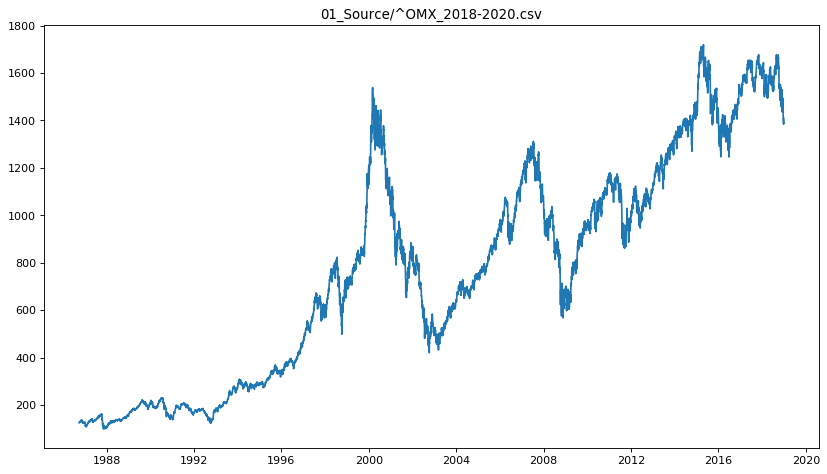

In [8]:
%matplotlib inline

import pandas as pd
import numpy as np
# import pandas_datareader as datareader
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

import DatavisualizationFunctions as vis
#from matplotlib.finance import candlestick_ohlc
# from mpl_finance import candlestick_ohlc

#%matplotlib inline
#%matplotlib notebook
#%matplotlib ipympl

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

##
source = pd.read_csv(conf['source_path'], sep=';')
source.index.name = "id"
source.columns = ['Date', 'Open', 'High', 'Low', 'Close']
source['Date'] = pd.to_datetime(source['Date'])
source['Date'].apply(mdates.date2num)
#df.head()

plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(source['Date'],source['Close'])
plt.title(default_test_config['source_path'])
plt.show()

## Class Generation

Here, 4 classes will be generated:
- LongTerm
- Intermediate term 20d
- Short term 5d
- very short term 1d

#### Create labels

In [9]:
##
y_labels = {
    'neutral' : 0,
    'positive' : 1,
    'negative':  2
}

### Calculate Tops and Bottoms

In [10]:
m=source.shape[0]
factor = 10000000
topsTemp = np.zeros([m, 4]);
topsTemp
bottomsTemp = np.ones([m, 4])*factor;
bottomsTemp
#close=source['Close']
#close

array([[10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.],
       ...,
       [10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.]])

In [11]:
# Get tops and bottoms from the chart
#Parameter
maxDecline = 0.02
maxIncrease = 0.02
factor = 10000000

#Format: Time, High, Low, Close
m=source.shape[0]

topsTemp = np.zeros([m, 4])
bottomsTemp = np.ones([m, 4])*factor

high=source['High']
low=source['Low']
close=source['Close']

#Run 1 for the rough tops and bottoms
for i, data in enumerate(source.values):
    #Get top
    if i>3 and i<m-3:
        #Decline close >2% from top high
        decline = (high[i] - min(close[i+1:i+2]))/high[i];
        if decline > maxDecline or high[i]==max(high[i-3:i+3]):
            #Top found
            topsTemp[i, 1]=high[i];
            #print("Top found at i={} value={}".format(i, high[i]));
    
    #%Get bottom
    if i>3 and i<m-3:
    #    %Decline close >2% from top high
        increase = (low[i] - max(close[i+1:i+2]))/low[i];
        if increase > maxIncrease or low[i]==min(low[i-3:i+3]):
            #Top found
            bottomsTemp[i, 1]=low[i];
            #print("Bottom found at i={} value={}".format(i, low[i]));

print("{} tops, {} bottoms found.".format(sum(topsTemp[:, 1]>0), sum(bottomsTemp[:, 1]<factor)));

#%Run 2 for exacter tops and bottoms
iTop = topsTemp[:,1];
iBottom = bottomsTemp[:,1];
for i, data in enumerate(source.values):
    #Tops
    if i>20 and i<m-20:
        if iTop[i]>0 and max(iTop[i-15:i+15])<=iTop[i]:
            topsTemp[i, 2]=iTop[i];
            #%fprintf("Intermediate top found at i=%i value=%.0f\n", i, iTop(i));
    
        if iBottom[i]<factor and min(iBottom[i-15:i+15])>=iBottom[i]:
            bottomsTemp[i, 2]=iBottom[i];
            #%fprintf("Intermediate bottom found at i=%i value=%.0f\n", i, iBottom(i));

bottomsTemp[bottomsTemp==factor]=0
bottoms=bottomsTemp[:, 2]
tops=topsTemp[:, 2]
print("Reduced to {} tops and {} bottoms.".format(sum(tops[:]>0), sum(bottoms[:]>0)));

1735 tops, 1233 bottoms found.
Reduced to 192 tops and 221 bottoms.


In [12]:
#topsTemp[topsTemp[:,1]>0]

In [13]:
#bottomsTemp[0:10,:]

##

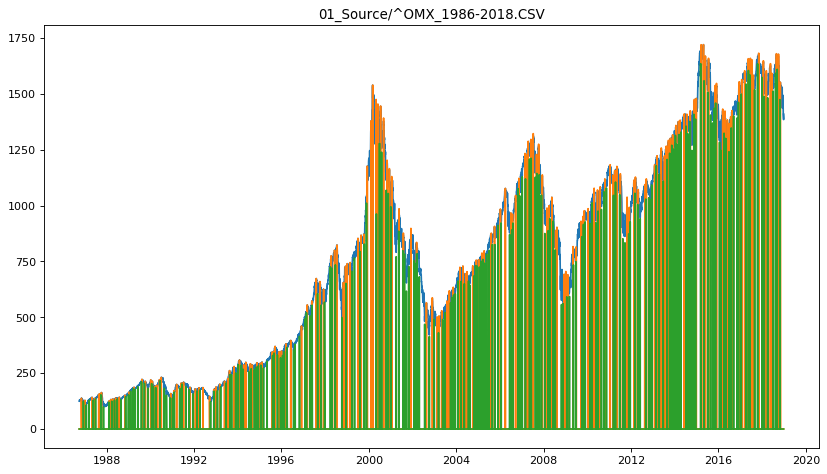

In [14]:
plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(source['Date'],source['Close'])
plt.plot(source['Date'], tops[:])
plt.plot(source['Date'], bottoms[:])
plt.title(conf['source_path'])
plt.show()

##

In [15]:
#Calculate the latest single event from a list of [0 0 0 0 2 0 0 1 0]->[0 0 0 0 2 2 2 2 1 1]
def calculateLatestEvent(eventList):
    previousItem=0;
    result = np.zeros(eventList.shape[0])
    for i in range(len(eventList)):
        if eventList[i]!=previousItem and eventList[i]!= 0:
            result[i]=eventList[i]
            previousItem=eventList[i]
        else: 
            result[i]=previousItem
    return result

latestBottoms = calculateLatestEvent(bottoms)
latestTops = calculateLatestEvent(tops)

##

In [16]:
#Calculate varios MA
#mov = pd.Series(np.arange(0, 100, 1), name='test')
#print(mov)
#Moving Average 
# mov: close
# n: Number of samples
# shift: shift of the window. shift < 0 future, shift > 0 history
def MA(mov, n, shift):  
    MA = mov.rolling(n).mean()
    #print(MA)
    source=pd.DataFrame(MA)
    source.columns = ['SMA' + str(n) + 'shift' + str(shift)]
    shiftedMA = source.shift(shift)
    
    return shiftedMA

In [17]:
ma50Future = MA(close, 50, -50)

##

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


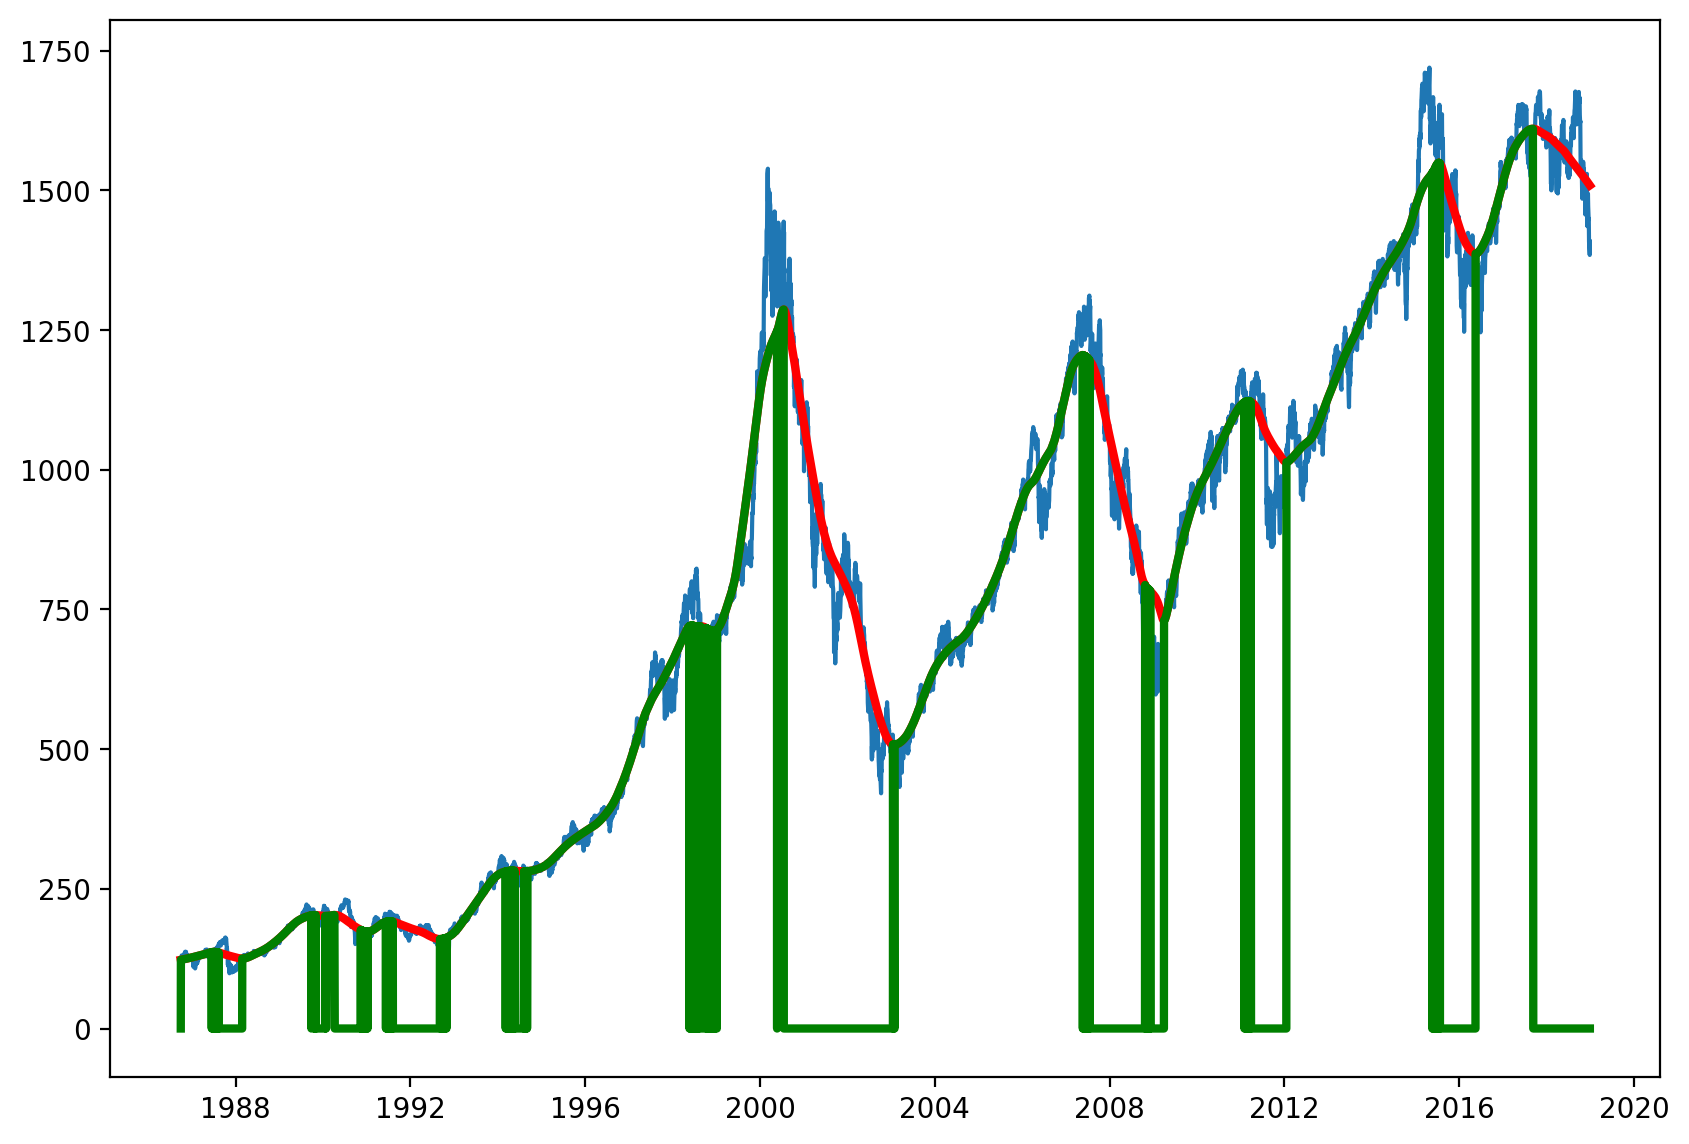

In [18]:
#Use Lowess to create a smoothed trend as an y value for a long trend
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
from scipy.ndimage.interpolation import shift

#Fraction for the lowess smoothing function
def calculate_lowess(days_to_consider, close, time):
    frac=days_to_consider/len(source['Close'])
    filtered = lowess(source['Close'], source['Date'], frac=frac)
    #Calculate the dlowess/dt to see if it is raising or declining
    shiftCol = filtered[:,1] - shift(filtered[:,1], 1, cval=np.NaN)
    pos_trend = shiftCol>0
    #print(pos_trend[0:5])

    fig = plt.figure(num=None, figsize=(10, 7), dpi=200, facecolor='w', edgecolor='k')
    plt.plot(source['Date'],source['Close'])
    plt.plot(source['Date'], filtered[:, 1], 'r-', linewidth=3)
    plt.plot(source['Date'], filtered[:, 1]*pos_trend, 'g-', linewidth=3)
    #plt.plot(source['Date'], filtered[:, 1]*pos_trend_cleaned, 'y-', linewidth=3)
    
    return pos_trend, fig

pos_trend_long, fig_long = calculate_lowess(300, source['Close'], source['Date'])
plt.gca()
plt.show()

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


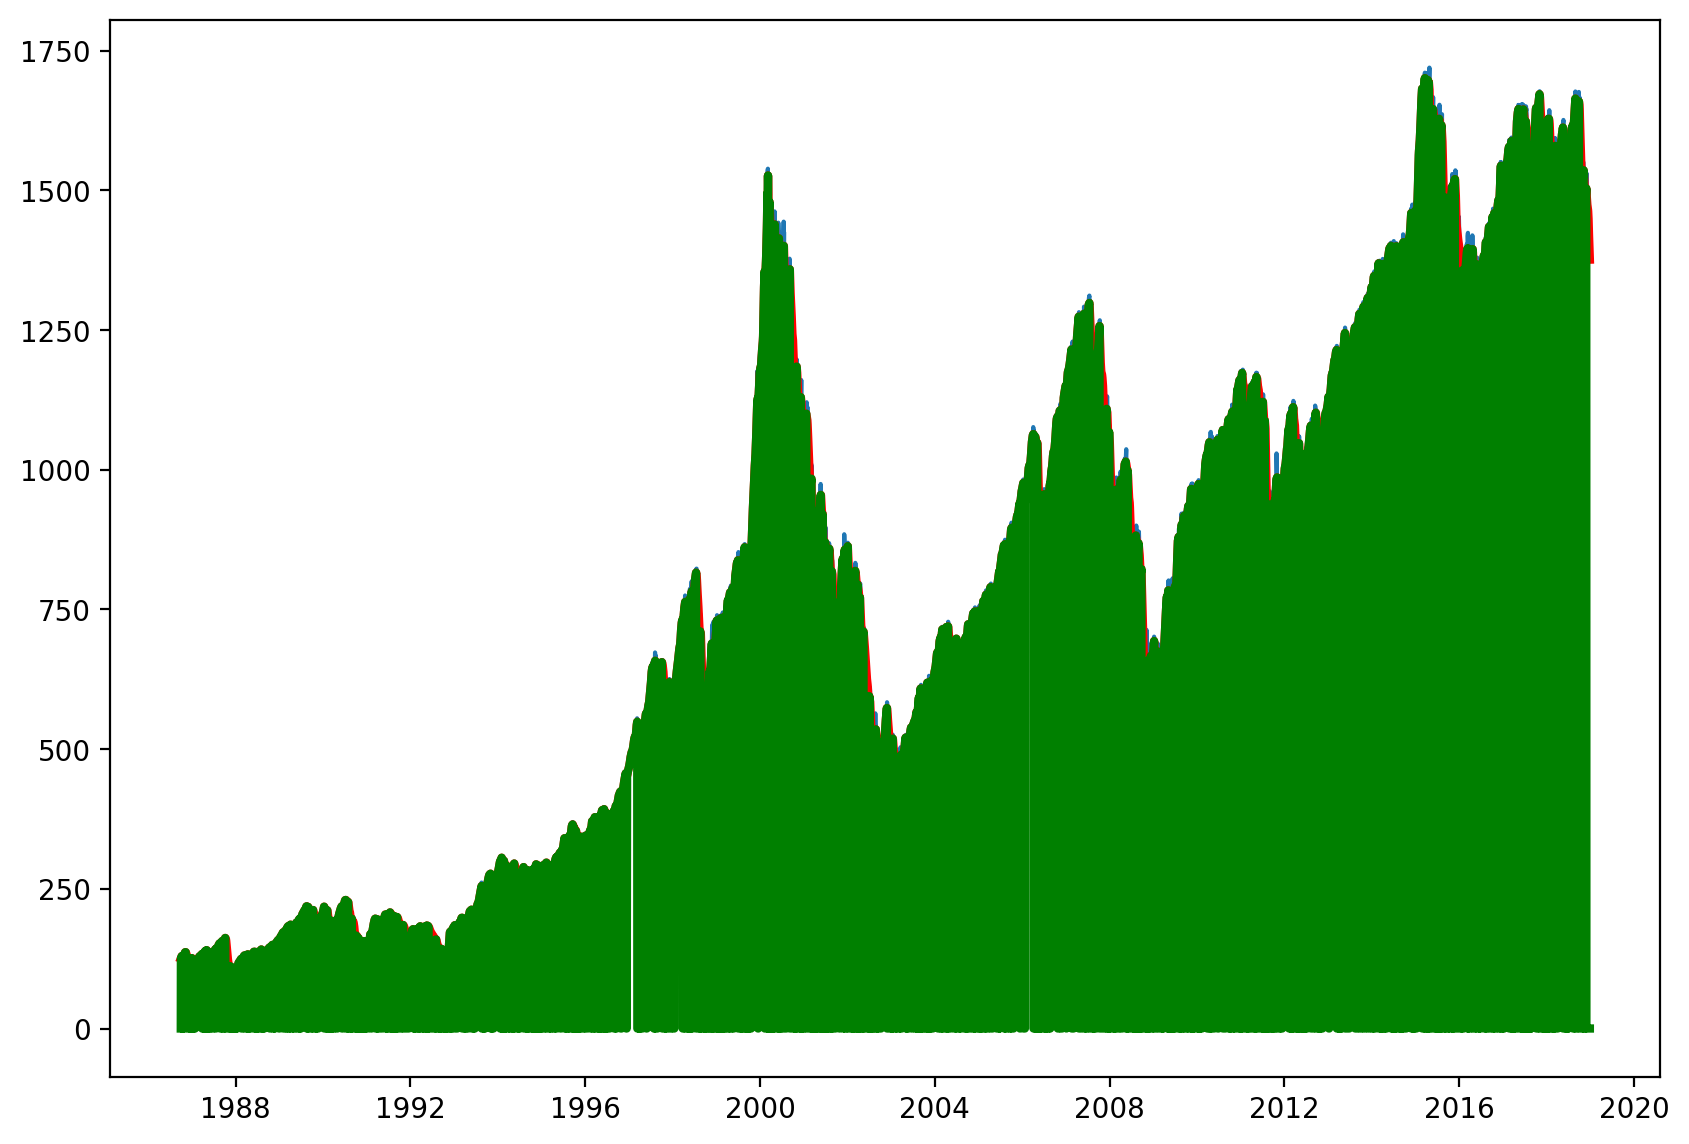

In [19]:
pos_trend_short, fig_short = calculate_lowess(10, source['Close'], source['Date'])
plt.gca()
plt.show()

### Calculate the Y values for 1d, 5d, 20d and the Long Trend

#

In [20]:
#Calculte the 1d trend

high=source['High']
low=source['Low']
close=source['Close']

y1day=np.zeros(m)
#Calculate the 5d trend
y5day=np.zeros(m)
#20d trend
y20day=np.zeros(m)
#long term trend
ylong=np.zeros(m)
signalLong=0;

for i in range(m-50):
    #=== 1d trend ===#
    if close[i+1]>close[i]:
        y1day[i]=1
    
    
    
    #=== 5day short trend ===#
    #if (pos_trend_short[i+10]==True) and (pos_trend_short[i+1]==True) and (pos_trend_short[i+2]==True) and (future_difference>0.001) and close[i+1]>close[i]:
    #Positive buy
    if i>5 and np.max(bottoms[i-5:i-1])>0 and np.mean(close[i+1:i+5])>close[i]:
        y5day[i]=1;
    
    #negtive, sell
    if i>5 and np.max(tops[i-5:i-1])>0 and np.mean(close[i+1:i+5])<close[i]:
        y5day[i]=2;
    
    #=== median trend 20d ===#
    if close[i+20]>close[i]:
        y20day[i]=1;
    
    #=== long term trend ===#
    #Trigger positive, buy
    if pos_trend_long[i] == True and close[i]>latestTops[i]:
        signalLong=1;
    #negative, sell
    elif pos_trend_long[i] == False and close[i]<latestBottoms[i]:
        signalLong=2;
    
    if signalLong==1:
        ylong[i] = 1;
    elif signalLong==2:
        ylong[i] = 2;
    else:
        ylong[i] = 0;

    #=== end ===#
print("y1day", sum(y1day))
print("y5day", sum(y5day))
print("y20day", sum(y20day))
print("ylong", sum(ylong))
print("Generated trends 1d, 5d, 20d, long.")

##

y1day 4240.0
y5day 1722.0
y20day 4771.0
ylong 10649.0
Generated trends 1d, 5d, 20d, long.


In [21]:
#Clean bad signals 1
previousSignalCount = sum(y1day)
for i in range(m-50):
    #If the signal is only valid for one or 2 days the signal was bad and
    #noisy. Only if the signal is valid for 3 days, it can be consideres as
    #a real signal
    if np.mean(y1day[i:i+3])<0.75:
        y1day[i]=0

print("Previous signal count y1day={}. New signal count={}".format(previousSignalCount, sum(y1day)))
print("Cleaned bad signals 1");

Previous signal count y1day=4240.0. New signal count=1214.0
Cleaned bad signals 1


In [22]:
#Clean bad signals 2, filter single days, enhance trend
print("signals y1day=", sum(y1day))
print("signals ylong=", sum(ylong))

#for i in range(m-50):
    # short term +1d
    #if i>1 and y1day[i-1]==0 and y1day[i+1]==0:
    #    y1day[i]=0;
    
    #long term, remove all values < 5 days to remove noise
    #use sliding window
    #if i>5 and ylong[i]==1:
    #    slideresult = np.zeros(5);
    #    for j in range(-5,0):
    #        slideresult[j+5] = np.mean(ylong[i+j:i+j+4])
    #    
    #    if max(slideresult)<1:
    #        ylong[i]=0;

print("signals y1day=", sum(y1day))
print("signals ylong=", sum(ylong))
print("Cleaned bad signals 2");

##

signals y1day= 1214.0
signals ylong= 10649.0
signals y1day= 1214.0
signals ylong= 10649.0
Cleaned bad signals 2


In [23]:
#Clean bad signals 3, filter single days
print("signals ylong=", sum(ylong))
for i in range(m-50):
    #long term, fill in all values < 5 days to remove noise
    #Fill gaps
    #Use sliding window
    if i>20-1 and ylong[i]==0 and np.mean(ylong[i-20:i+20])>0.5:
        ylong[i]=1;
    
    #Enhance the trend to run as far as possible
    if i>=1 and ylong[i-1]==1 and ylong[i]==0 and close[i]>latestBottoms[i]:
        ylong[i]=1;

print("signals ylong=", sum(ylong))
print("Cleaned bad signals 3.");

signals ylong= 10649.0
signals ylong= 10649.0
Cleaned bad signals 3.


In [24]:
#Merge all y values to the series start
outcomes=pd.DataFrame(index=source.index).join(
    pd.Series(y1day, name="1dTrend").astype('int64')).join(
    pd.Series(y5day, name="5dTrend").astype('int64')).join(
    pd.Series(y20day, name="20dTrend").astype('int64')).join(
    pd.Series(ylong, name="LongTrend").astype('int64'))
#result = [source array2table([tops bottoms y1day y5day y20day ylong], 'VariableNames',{'Tops', 'Bottoms', 'answer1d', 'answer5d', 'answer20d', 'answerLong'})];
#result(end-100:end,:)=[];

##

In [25]:
if cut_data == True:
    #Drop the 50 last values as they cannot be used for prediction as +50 days ahead is predicted
    outcomes_cut = outcomes.drop(outcomes.tail(50).index, inplace=False)
    #Drop from the timerows too
    source_cut = source.drop(source.tail(50).index, inplace=False)
else:
    source_cut = source
    outcomes_cut = outcomes

#fprintf("Finish\n");
display(outcomes_cut.head())
display(outcomes_cut.tail())

##
#merged_source.shape
#source.shape

,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,
0,1,0,1,0
1,1,0,1,1
2,1,0,1,1
3,1,0,1,1
4,0,0,1,1


,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,
8048,0,2,0,2
8049,0,0,0,2
8050,0,0,0,2
8051,0,0,0,2
8052,0,0,0,2


In [26]:
#def amplifyForPlot(binaryArray, targetArray, distance):
#    return binaryArray * targetArray * (1-distance)
#amplifyForPlot(merged_df['LongTrend'], merged_df['Close'], 0.01)

#### Plot 3 class data

%matplotlib notebook

def plot_three_class_graph(y0, y1, y2, y_ref, y_time, offset1, offset2, offset3, legend):
    
    plot_data_OK = amplifyForPlot(y0, y_ref, offset1)
    plot_data_blim = amplifyForPlot(y1, y_ref, offset2)
    plot_data_tlim = amplifyForPlot(y2, y_ref, offset3)
    
    # Plot test data
    plt.figure(num=None, figsize=(11.5, 7), dpi=80, facecolor='w', edgecolor='k')

    plt.plot(y_time, y_ref)
    plt.plot(y_time, plot_data_OK, color='grey')
    plt.plot(y_time, plot_data_blim, color='green')
    plt.plot(y_time, plot_data_tlim, color='red')
    plt.title("Prediction Results")
    plt.ylim([np.min(y_ref)*0.99999, np.max(y_ref)*1.00002])
    plt.grid()
    plt.legend(legend)
    plt.show()

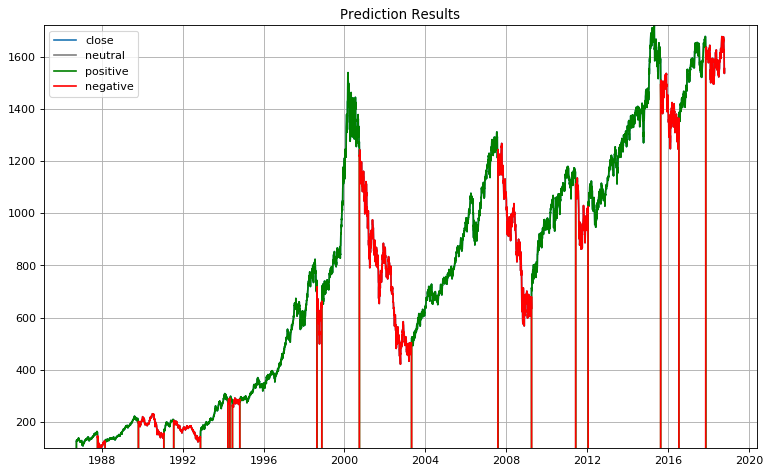

In [46]:
#Present long term term data
vis.plot_three_class_graph(outcomes_cut['LongTrend'].values, source_cut['Close'],
                           source_cut['Date'], 0,0,0,('close', 'neutral', 'positive', 'negative'))
plt.show()

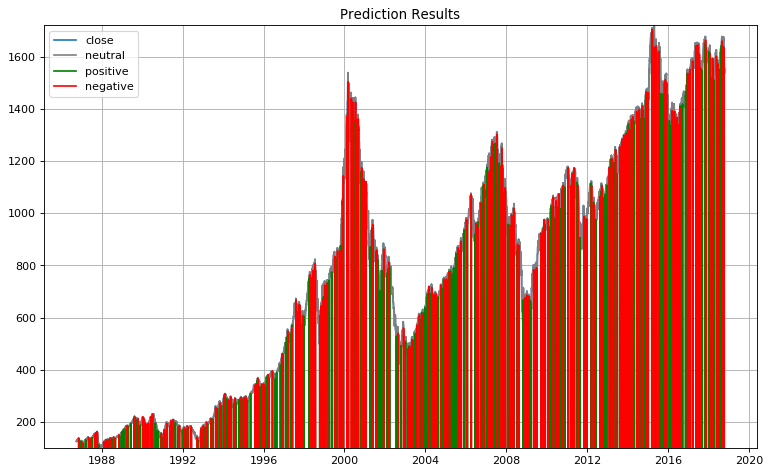

In [28]:
#Present short term data
vis.plot_three_class_graph(outcomes_cut['5dTrend'].values, source_cut['Close'],
                           source_cut['Date'], 0,0,0,('close', 'neutral', 'positive', 'negative'))
plt.show()


##

#### Plot 2 class data

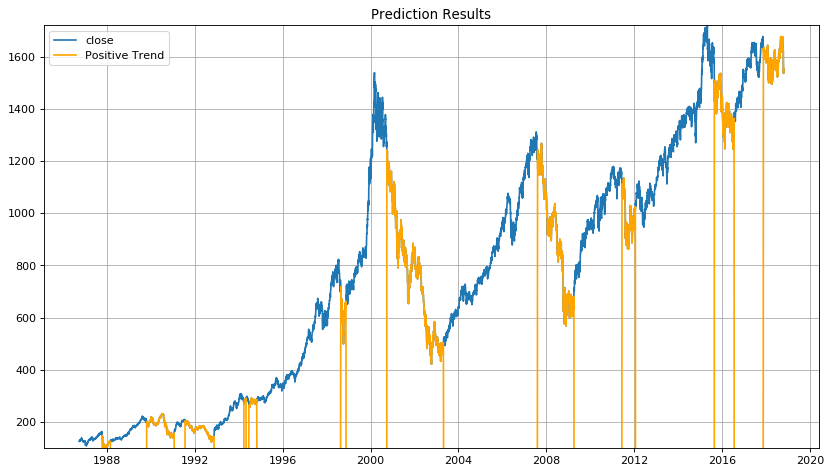

In [29]:
vis.plot_two_class_graph(outcomes_cut['LongTrend']-1, source_cut['Close'], source_cut['Date'], 0, ('close', 'Positive Trend'))

In [30]:
#Outcomes
#Rename cut outcomes to outcomes
outcomes = outcomes_cut
display(outcomes.head(5))

,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,
0,1,0,1,0
1,1,0,1,1
2,1,0,1,1
3,1,0,1,1
4,0,0,1,1


## Generate Features from Raw Data
Generate features based on price data X

Data structure generated: features

In [31]:
#Inputs
close = source_cut['Close']
high = source_cut['High']
low = source_cut['Low']

#Define features df
features = pd.DataFrame(index=outcomes.index)

In [32]:
def generate_smoothed_trigger(values, alpha=0.5, tailclip=0.1):
    ''' From a value array with signals in the range -1, 0, 1, generate smoothed decay'''
    
    smoothed_sign_change = np.zeros(values.shape)
    for i, value in enumerate(values):
        previous_value = 0.0
        if i>0:
            previous_value = smoothed_sign_change[i-1]
        if np.isnan(value):
            value = 0
        
        #Now use expoential smoothing to smooth the values 
        def exponential_smoothing(current_value, previous_value, alpha=alpha, tailclip=tailclip):
            new_value = current_value + (1-alpha) * previous_value
            if current_value==1 or current_value ==-1:
                new_value = current_value
            
            if new_value<-1:
                newValue = -1
            elif new_value>1:
                new_value = 1
            elif np.abs(new_value)<tailclip:
                new_value = 0
            
            return new_value
        
        smoothed_sign_change[i] = np.round(exponential_smoothing(value, previous_value, alpha=0.4, tailclip=0.1), 3)
        #print("new val: {}, Val: {}, prev val: {}".format(smoothed_sign_change[i], value, previous_value))
    
    return smoothed_sign_change

def cscheme(colors):
    aliases = {
        'BkBu': ['black', 'blue'],
        'gr': ['green', 'red'],
        'grays': ['silver', 'gray'],
        'mas': ['black', 'green', 'orange', 'red'],
    }
    aliases['default'] = aliases['gr']
    return aliases[colors]

def machart(kind, fast, medium, slow, append=True, last=last_, figsize=price_size, colors=cscheme('mas')):
    title = ctitle(f"{kind.upper()}s", ticker=ticker, length=last)
    ma1 = df.ta(kind=kind, length=fast, append=append)
    ma2 = df.ta(kind=kind, length=medium, append=append)
    ma3 = df.ta(kind=kind, length=slow, append=append)
    
    madf = pd.concat([closedf, df[[ma1.name, ma2.name, ma3.name]]], axis=1, sort=False).tail(last)
    madf.plot(figsize=figsize, title=title, color=colors, grid=True)    

def volumechart(kind, length=10, last=last_, figsize=ind_size, alpha=0.7, colors=cscheme('gr')):
    title = ctitle("Volume", ticker=ticker, length=last)
    volume = pd.DataFrame({'V+': volumedf[closedf > opendf], 'V-': volumedf[closedf < opendf]}).tail(last)
    
    volume.plot(kind='bar', figsize=figsize, width=0.5, color=colors, alpha=alpha, stacked=True)
    vadf = df.ta(kind=kind, close=volumedf, length=length).tail(last)
    vadf.plot(figsize=figsize, lw=1.4, color='black', title=title, rot=45, grid=True)


### Generate Price Based Values

#### Max and Min Price Values
Normalize the price compared to e.g. the last 200 days to find new highs and lows.

In [33]:
#5d, 20d, 100d, and 200d norm value from [0,1]

#list of normed days that are interesting
normed_days=[5, 20, 50, 100, 200]

normed_days_features = pd.DataFrame(index=features.index)

for d in normed_days:
    temp_col = np.zeros(close.shape)
    for i, c in enumerate(close[:]):
        if i>=d:
            min_value = np.min(close[i-d+1:i+1])
            max_value = np.max(close[i-d+1:i+1])
            current_value = close[i]
        
            normed_value  = (current_value-min_value)/(max_value - min_value)
            temp_col[i]=normed_value
        else:
            temp_col[i]=np.nan
        
        #display(close[i-4:i+1])
        #print(close[i])
        #normed_column = (close[i]-np.min(close[i-4:i+1]))/(np.max(close[i-5:i])-np.min(close[i-5:i]))
    
    normed_days_features = normed_days_features.join(pd.DataFrame(temp_col, columns=['NormKurs' + str(d)]))
#display(close[190:210])
#normed_days_features.iloc[190:210]

print("Number of features: {}".format(normed_days_features.shape))
features = features.join(normed_days_features)

display(normed_days_features.head(10))

Number of features: (8053, 5)


,NormKurs5,NormKurs20,NormKurs50,NormKurs100,NormKurs200
id,,,,,
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,1.000000,NaN,NaN,NaN,NaN
6,1.000000,NaN,NaN,NaN,NaN
7,0.940758,NaN,NaN,NaN,NaN
8,0.425455,NaN,NaN,NaN,NaN


#### Number of last days increase/decrease

a = np.where(diff[0:20]>0)
a[0].shape[0]/20

In [34]:
#In the last 10days, the price increased x% of the time. 1=all days, 0=no days

#list of normed days that are interesting
number_days=[5, 20, 50, 100, 200]

number_days_features = pd.DataFrame(index=features.index)

diff = close-close.shift(1)

for n in number_days:
    temp_col = np.zeros(diff.shape)
    for i, c in enumerate(diff[:]):
        if i>=n:
            rise_value = np.where(diff[i-n+1:i+1]>0)[0].shape[0]/n
            temp_col[i]=rise_value
        else:
            temp_col[i]=np.nan
        
        #display(close[i-4:i+1])
        #print(close[i])
        #normed_column = (close[i]-np.min(close[i-4:i+1]))/(np.max(close[i-5:i])-np.min(close[i-5:i]))
    
    number_days_features = number_days_features.join(pd.DataFrame(temp_col, columns=['NumberRise' + str(n)]))
#display(close[0:20])
#normed_days_features.iloc[190:210]

print("Number of features: {}".format(number_days_features.shape))
features = features.join(number_days_features)

display(number_days_features.head(100))

Number of features: (8053, 5)


,NumberRise5,NumberRise20,NumberRise50,NumberRise100,NumberRise200
id,,,,,
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
95,0.8,0.60,0.50,NaN,NaN
96,0.8,0.65,0.50,NaN,NaN
97,1.0,0.65,0.52,NaN,NaN


### Generate mean values

In [35]:
# Generate features - Mean value 
meanList = [2, 5, 8, 10, 13, 15, 18, 20, 22, 34, 40, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400];
#meanList = [5 10 20 50 100 1 50 200]';
#meanList = [5, 10, 20, 50, 100, 200];
#meanList = [5]

meanfeatures = pd.DataFrame(index=features.index)

for i in meanList:
    #Mean
    meanCol=MA(close, i, 0); #Trailing MA with i
    #meanCol.fillna(0, inplace=True)
    meanColreshaped = np.reshape(meanCol.values, (1,np.product(meanCol.values.shape)))[0]
    #Calculate diff from price in %
    diffPriceCol = np.divide(meanColreshaped - close.values, close.values)
    temp_source = pd.DataFrame(diffPriceCol, columns=['MA' + str(i) + 'Norm'])
    #print(temp_source)
    meanfeatures = meanfeatures.join(temp_source)
    #meanTable(:,i) = diffPriceCol;
    #print("Calculated MA{}".format(i));

print("Number of features: {}".format(meanfeatures.shape))

features = features.join(meanfeatures)

display(meanfeatures.head())

Number of features: (8053, 26)


,MA2Norm,MA5Norm,MA8Norm,MA10Norm,MA13Norm,MA15Norm,MA18Norm,MA20Norm,MA22Norm,MA34Norm,...,MA175Norm,MA200Norm,MA225Norm,MA250Norm,MA275Norm,MA300Norm,MA325Norm,MA350Norm,MA375Norm,MA400Norm
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.003693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.001267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.001697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.005735,-0.01364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Generate mean value directions

In [36]:
#Create empty dataframe for the differences between the current time and previous time
madiff_features = pd.DataFrame(index=features.index)

for col in meanfeatures.columns:
    currentCol = meanfeatures[col]
    shiftCol = meanfeatures[col].shift(1)
    diff = currentCol-shiftCol
    diff.name = col + 'Diff'
    #display(currentCol)
    #display(shiftCol)
    madiff_features = madiff_features.join(diff)
    
print("Number of features: {}".format(madiff_features.shape))

features = features.join(madiff_features)

display(madiff_features.head())

Number of features: (8053, 26)


,MA2NormDiff,MA5NormDiff,MA8NormDiff,MA10NormDiff,MA13NormDiff,MA15NormDiff,MA18NormDiff,MA20NormDiff,MA22NormDiff,MA34NormDiff,...,MA175NormDiff,MA200NormDiff,MA225NormDiff,MA250NormDiff,MA275NormDiff,MA300NormDiff,MA325NormDiff,MA350NormDiff,MA375NormDiff,MA400NormDiff
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.002425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.000430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.004038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Generate RSI

In [37]:
#from talib import RSI
#import ta   #https://github.com/bukosabino/ta
import pandas_ta as ta   #https://github.com/twopirllc/pandas-ta

rsiList = [2, 3, 5, 9, 10, 14, 20, 25];

rsi_features = pd.DataFrame(index=features.index)

for i in rsiList:
    #rsi(close, length=None, drift=None, offset=None, **kwargs)
    rsicol = ta.rsi(close, length=i)
    rsi_features = rsi_features.join(rsicol)

print("Number of features: {}".format(rsi_features.shape))
display(rsi_features.head(20))

features = features.join(rsi_features)

Number of features: (8053, 8)


,RSI_2,RSI_3,RSI_5,RSI_9,RSI_10,RSI_14,RSI_20,RSI_25
id,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
3,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
4,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
5,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
6,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
7,90.052236,92.832525,95.336648,97.239738,97.495215,98.172561,98.700615,98.953036
8,50.201054,61.543178,73.465385,83.599468,85.031321,88.911212,92.021368,93.534896


### Generate RSI difference

In [38]:
#RSI shift, in which direction it is moving
import pandas_ta as ta   #https://github.com/twopirllc/pandas-ta

rsi_values = rsiList
rsi_change_features = pd.DataFrame(index=features.index)

for period in rsi_values:
    rsi=ta.rsi(close, length=period)
    #Other column, here the same column shifted to find out if the direction changes 
    rsi_diff = rsi-rsi.shift(1)
    rsi_diff.name = 'RSI' + str(period) + '_diff'
    rsi_change_features = rsi_change_features.join(rsi_diff)

print("Number of features: {}".format(rsi_change_features.shape))
display(rsi_change_features.head(10))
    
features = features.join(rsi_change_features)

Number of features: (8053, 8)


,RSI2_diff,RSI3_diff,RSI5_diff,RSI9_diff,RSI10_diff,RSI14_diff,RSI20_diff,RSI25_diff
id,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-1.421085e-14,0.000000
3,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.421085e-14,0.000000
4,0.000000,-1.421085e-14,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
5,0.000000,1.421085e-14,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
6,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
7,-9.947764,-7.167475e+00,-4.663352,-2.760262,-2.504785,-1.827439,-1.299385e+00,-1.046964
8,-39.851182,-3.128935e+01,-21.871263,-13.640270,-12.463894,-9.261349,-6.679247e+00,-5.418141


### RSIx < value
If RSI3 < 2 give signal, buying signal

In [39]:
# If RSI3 < 2 give signal, buying signal
rsi_signal_features = pd.DataFrame(index=features.index)

rsi3=ta.rsi(close, length=3)
rsi3_signal = (rsi3 < 5)*1
rsi3_decay_signal = generate_smoothed_trigger(rsi3_signal)
rsi_signal_features = rsi_signal_features.join(pd.DataFrame(rsi3_decay_signal, columns=['RSI' + str(3) + 'sign']))

print("Number of features: {}".format(rsi_signal_features.shape))
display(rsi_signal_features[rsi_signal_features['RSI3sign']==1].head(10))

### DISPLAY IN GRAPH ####

features = features.join(rsi_signal_features)    

Number of features: (8053, 1)


,RSI3sign
id,
70,1.0
155,1.0
263,1.0
849,1.0
978,1.0
1000,1.0
1001,1.0
1002,1.0
1003,1.0


### Generate RSI5 Signal
### FIXME
If RSI5 < 50 and decreasing, then the probability is high that it goes < 20 too and the price is lower

In [40]:
#rsi = rsi_features["RSI5"] 
#rsi_diff = rsi_change_features["RSI5_diff"]

#rsi_break_through = pd.DataFrame(index=features.index)

#if previous value>50, this value<50 and diff <0
#rsi_break_through = np.logical_and(rsi.shift(1).values>50, rsi.values<50, rsi_diff.values<0)
#rsi5=RSI(close, timeperiod=5)
#Other column, here the same column shifted to find out if the direction changes
#rsi5shift = rsi5.shift(1)
#display(rsi5.iloc[0:20])
#display(rsi5shift.iloc[0:20])

#rsi5_change = pd.DataFrame(index=features.index)

#rsi5_change = (rsi5<50 and rsi5shift>50)
#display(rsi5_change[0:20])
    
#rsi5_change_smoothed = generate_smoothed_trigger(rsi5_change)
#macd_direction_change_features = macd_direction_change_features.join(pd.Series(data=smoothed_sign_change, name=col + 'DirChange'))
    
#macd_direction_change_features.iloc[90:100]



### Generate Stochastic

In [41]:
#import pandas_ta as ta   #https://github.com/twopirllc/pandas-ta

#help(ta.stoch)

Parameter: fastk=13, slowk=8, slowd=3
Parameter: fastk=5, slowk=3, slowd=3
Parameter: fastk=21, slowk=7, slowd=7
Parameter: fastk=21, slowk=14, slowd=14
Parameter: fastk=3, slowk=14, slowd=14
Number of features: (8053, 10)


,Stoch_Sk1383,Stoch_Sd1383,Stoch_Sk533,Stoch_Sd533,Stoch_Sk2177,Stoch_Sd2177,Stoch_Sk211414,Stoch_Sd211414,Stoch_Sk31414,Stoch_Sd31414
id,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,97.354497,97.354497,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,83.597884,83.597884,NaN,NaN,NaN,NaN,NaN,NaN


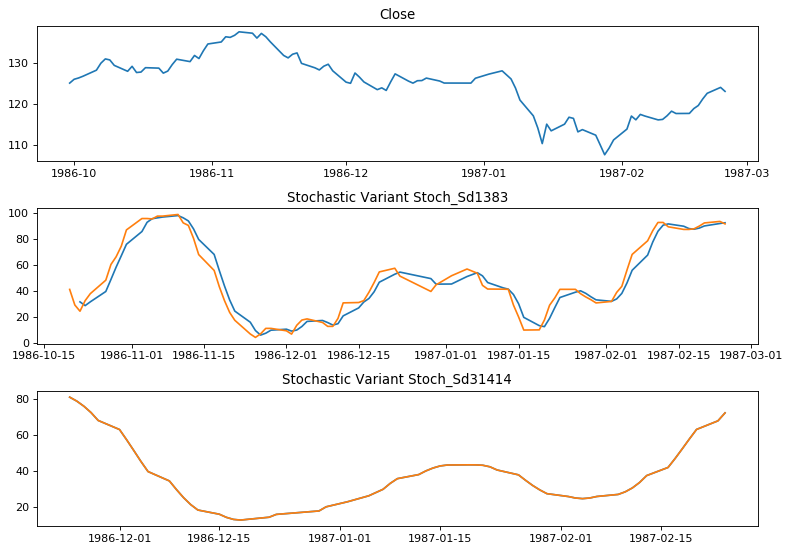

In [42]:
#from talib import STOCH
import pandas_ta as ta   #https://github.com/twopirllc/pandas-ta

#Recommended stochastics: [fk, sk, sd], [5,3,3], [21,7,7], [21,14,14]

fastk_parameter = [13, 5, 21, 21, 3]
slowk_parameter = [3, 3, 7, 14, 14]
slowd_parameter = [8, 3, 7, 14, 14]

stoch_features = pd.DataFrame(index=features.index)

for fk, sd, sk in zip(fastk_parameter, slowk_parameter, slowd_parameter):
    print("Parameter: fastk={}, slowk={}, slowd={}".format(fk, sk, sd))
    
    df=ta.stoch(high, low, close, fast_k=fk, slow_k=sk, slow_d=sd)
    #print(df.columns)
    
    #print(pd.Series(df['STOCH_' + str(sk)], name='Stoch_Sk' + str(fk)+str(sk)+str(sd)))
    
    stoch_features = stoch_features.join(pd.Series(df['STOCH_' + str(sk)], name='Stoch_Sk' + str(fk)+str(sk)+str(sd)))
    stoch_features = stoch_features.join(pd.Series(df['STOCH_' + str(sd)], name='Stoch_Sd' + str(fk)+str(sk)+str(sd)))

display(stoch_features.head(50))
print("Number of features: {}".format(stoch_features.shape))

plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k') 
plt.subplot(311) 
plt.plot(source_cut['Date'][0:100],source_cut['Close'][0:100])
plt.title("Close")
plt.subplot(312)
plt.title("Stochastic Variant " + str(stoch_features.columns[1]))
plt.plot(source_cut['Date'][0:100],stoch_features.iloc[:,1][0:100]) 
plt.plot(source_cut['Date'][0:100],stoch_features.iloc[:,0][0:100])
plt.subplot(313) 
plt.title("Stochastic Variant " + str(stoch_features.columns[-1]))
plt.plot(source_cut['Date'][0:100],stoch_features.iloc[:,-1][0:100]) 
plt.plot(source_cut['Date'][0:100],stoch_features.iloc[:,-2][0:100])
plt.tight_layout()

features = features.join(stoch_features)

### MACD

In [43]:
help(ta.macd)

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)
    
    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram.  The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.
    
    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
    
    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal
    
    Args:
        close (pd.Series): Series of 'close's
        fast (int): The short period.  Default: 12
        slow (int): The long period.   Default: 26
        signal 

In [44]:
#from talib import MACDEXT
import pandas_ta as ta   #https://github.com/twopirllc/pandas-ta

#MACD
#Recommended parameters: 12_26_9, 5, 35, 5
fast_macd = [12, 5]
slow_macd = [26, 35]
signal_macd = [9, 5]

macd_features = pd.DataFrame(index=features.index)

#def ctitle(indicator_name, ticker='SPY', length=100):
#    return f"{ticker}: {indicator_name} from {recent_startdate} to {recent_startdate} ({length})"

#recent_startdate = source_cut.tail(recent).index[0]
#recent_enddate = source_cut.tail(recent).index[-1]
#price_size = (16, 8)
#ind_size = (16, 2)
#ticker = 'SPY'
#recent = 126
#half_of_recent = int(0.5 * recent)

#def plot_MACD(macddf):
#    macddf[[macddf.columns[0], macddf.columns[2]]].tail(recent).plot(figsize=(16, 2), color=cscheme('BkBu'), linewidth=1.3)
#    macddf[macddf.columns[1]].tail(recent).plot.area(figsize=ind_size, stacked=False, color=['silver'], linewidth=1, title=ctitle(macddf.name, ticker=ticker, length=recent), grid=True).axhline(y=0, color="black", lw=1.1)

for fmacd, smacd, sigmacd in zip(fast_macd, slow_macd, signal_macd):
    print("Generate fast mcd={}, slow macd={}, signal macd={}".format(fmacd, smacd, sigmacd))
    macddf = ta.macd(close, fast=fmacd, slow=smacd, signal=sigmacd)
    #display(macddf.iloc[:,0].head(50))
    #plot_MACD(macddf)
    
    macd_features = macd_features.join(pd.Series(macddf[macddf.columns[0]], name='MACD_' + str(fmacd) + "_" + str(smacd)+  "_" + str(sigmacd)))
    macd_features = macd_features.join(pd.Series(macddf[macddf.columns[2]], name='MACDS_' + str(fmacd) + "_" + str(smacd)+  "_" + str(sigmacd)))

print("Number of features: {}".format(macd_features.shape))
display(macd_features.iloc[20:40,:])

plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k') 
plt.subplot(311) 
plt.plot(source_cut['Date'][0:100],source_cut['Close'][0:100])
plt.title("Close")
plt.subplot(312)
plt.title("MACD Variant 1")
plt.plot(source_cut['Date'][0:100], macd_features.iloc[:,0][0:100]) 
plt.plot(source_cut['Date'][0:100], macd_features.iloc[:,1][0:100])
plt.legend(("MACD", "MACD Signal"))
plt.subplot(313)
plt.title("MACD Variant 1")
plt.plot(source_cut['Date'][0:100], macd_features.iloc[:,-2][0:100]) 
plt.plot(source_cut['Date'][0:100], macd_features.iloc[:,-1][0:100])
plt.legend(("MACD", "MACD Signal"))
plt.tight_layout()

macddf = ta.macd(close, fast=8, slow=21, signal=9, min_periods=None, append=True)

features = features.join(macd_features)

Generate fast mcd=12, slow macd=26, signal macd=9


KeyboardInterrupt: 

### MACD Difference

In [ ]:
#MACD direction
import pandas_ta as ta   #https://github.com/twopirllc/pandas-ta

#Create empty dataframe for the differences between the current time and previous time
macd_diff_features = pd.DataFrame(index=features.index)

for col in macd_features.columns:
    currentCol = macd_features[col]
    shiftCol = macd_features[col].shift(1)
    diff = currentCol-shiftCol
    diff.name = col + 'Diff'
    #display(currentCol)
    #display(shiftCol)
    macd_diff_features = macd_diff_features.join(diff)
    
print("Number of features: {}".format(macd_diff_features.shape))

features = features.join(macd_diff_features)

display(macd_diff_features.iloc[30:40])

### Signals for Trigger

In [ ]:
#If MACD changes direction
macd_direction_change_features = pd.DataFrame(index=features.index)

for col in macd_diff_features.columns:
    #Column to find signal on
    currentCol = macd_diff_features[col]
    #Other column, here the same column shifted to find out if the direction changes
    shiftCol = macd_diff_features[col].shift(1)
    
    display(currentCol.iloc[90:100])
    #display(shiftCol.iloc[30:60])
    
    #Multiply current diff with previous diff and get the sign of the product. If sign is negative, then direction change
    #has occured. The multiply with the sign of the current value to get the sign of the direction change. If 1, then
    #it was a change from negative to positive. If it was negative, then it was a change from negative to positive
    signChange = (np.sign(currentCol*shiftCol)==-1)*1*np.sign(currentCol)
    display(signChange[90:100])
    
    smoothed_sign_change = generate_smoothed_trigger(signChange)
    macd_direction_change_features = macd_direction_change_features.join(pd.Series(data=smoothed_sign_change, name=col + 'DirChange'))

print("Number of features: {}".format(macd_direction_change_features.shape))

features = features.join(macd_direction_change_features)

macd_direction_change_features.iloc[90:100]

In [ ]:
#rsi5shift

### Periodical indicators

In [ ]:
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

In [ ]:
#Generate periodical values
periodic_values = pd.DataFrame(index=features.index)
timelist = source['Date']
# Get month of year
periodic_values['month_of_year'] = timelist.apply(lambda x: x.month)
# Get week of year
periodic_values['week_of_year'] = timelist.apply(lambda x: x.week)
# Get day of year
periodic_values['day_of_year'] = timelist.apply(lambda x: x.timetuple().tm_yday)
# Get day of month
periodic_values['day_of_month'] = timelist.apply(lambda x: x.day)
# Get day of week
periodic_values['day_of_week'] = timelist.apply(lambda x: x.weekday())
# Get week of month
periodic_values['week_of_month'] = timelist.apply(week_of_month)
display(periodic_values.head())

In [ ]:
#Make one-hot-encoding of the values as they do not depend on each other
from sklearn.preprocessing import OneHotEncoder

#One hot encoding for day of week
periodic_values = periodic_values.join(pd.get_dummies(periodic_values['day_of_week'], prefix='day_week_')).drop(['day_of_week'], axis=1)
#For special weeks, there are day of week 5 and 6. Remove them, as they are special cases
periodic_values.drop(columns=['day_week__5', 'day_week__6'], errors='ignore', inplace=True)

#One hot encoding for month of year
periodic_values = periodic_values.join(pd.get_dummies(periodic_values['month_of_year'], prefix='month_year_')).drop(['month_of_year'], axis=1)

#One hot encoding week of month
periodic_values = periodic_values.join(pd.get_dummies(periodic_values['week_of_month'], prefix='week_month_')).drop(['week_of_month'], axis=1)

print("Number of features: {}".format(periodic_values.shape))

features = features.join(periodic_values)

display(periodic_values.head())
#onehot_encoder = OneHotEncoder(sparse=False)
i#nteger_encoded = integer_encoded.reshape(len(integer_encoded), 1)
#onehot_encoded = onehot_encoder.fit_transform(periodic_values['day_of_week'])
#print(onehot_encoded)

### Candlestick patterns

Link: https://mrjbq7.github.io/ta-lib/func_groups/pattern_recognition.html

from talib import CDL2CROWS, CDL3BLACKCROWS, CDL3INSIDE

#FIXME: Get Open and create the patterns


pattern1 = CDL2CROWS(close, high, low, close)
pattern1 = CDL3BLACKCROWS(close, high, low, close)
i = CDL3INSIDE(close, high, low, close)
display(np.sum(pattern1))

### Show Features

In [ ]:
#Features structure
display(features.head(100))
display(features.shape)

## Create files

### Clean NaNs

In [ ]:
#Assign the columns to X and y
#Clean the featurestable and make an array or it
#Drop all NaN rows
nan_index = pd.isnull(features).any(1).nonzero()[0]
print("Found {} rows with NaN".format(len(nan_index)))
#Drop for features
features_nonan=features.drop(nan_index)
#Drop for outcomes
outcomes_nonan=outcomes.drop(nan_index)
#Drop for source
source_cut_nonan=source_cut.drop(nan_index)

#print("New index range=", featues_nonan.index)
print("Got features features shape={}, outcomes shape={}, source shape={}".format(features_nonan.shape, outcomes_nonan.shape, source_cut_nonan.shape))

display(features_nonan.head(5))
display(features_nonan.tail(5))
display(source_cut_nonan.head(5))
display(source_cut_nonan.tail(5))

### Save to File

In [ ]:
import csv

#Save features to a csv file
print("Features shape {}".format(features_nonan.shape))
features_nonan.to_csv(features_filename, sep=';', index=True, header=True)
print("Saved features to " + features_filename)

#Save outcomes to a csv file
print("Outcomes shape {}".format(outcomes_nonan.shape))
outcomes_nonan.to_csv(outcomes_filename, sep=';', index=True, header=True)
print("Saved outcomes to " + outcomes_filename)

#Save the graph data for visualization of the results
print("source shape {}".format(source_cut_nonan.shape))
source_cut_nonan.to_csv(source_filename, sep=';', index=True, header=True)
print("Saved source graph to " + source_filename)

#Save y labels to a csv file as a dict
print("Class labels length {}".format(len(y_labels)))
with open(labels_filename, 'w') as f:
    for key in y_labels.keys():
        f.write("%s;%s\n"%(key,y_labels[key]))
print("Saved class names and id to " + labels_filename)

print("=== Data for {} prepared to be trained ===". format(conf['dataset_name']))

# Debug and Experiment
debug and test functions used to create the script

## Lowess Estimation of the Main Trend

from statsmodels.nonparametric.smoothers_lowess import lowess

#df['Time'],df['Close']
#print(len(df['Close']))
frac=300/len(df['Close'])
filtered = lowess(df['Close'], df['Time'], frac=frac)
#frac2=50/len(df['Close'])
#filtered2 = lowess(filtered[:,1], df['Time'], frac=frac2)

#def amplifyForPlot(binaryArray, targetArray, distance):
#    return binaryArray * targetArray * (1-distance)

import numpy as np
from scipy.ndimage.interpolation import shift

shiftCol = filtered[:,1] - shift(filtered[:,1], 1, cval=np.NaN)
pos_trend = shiftCol>0
pos_trend
#squarer = lambda x: x
#vfunc = np.vectorize(squarer)
#vfunc(x)
#np.mapp([filtered[:, 1]*[len(shiftCol>0)

plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['Time'],df['Close'])
plt.plot(df['Time'], filtered[:, 1], 'r-', linewidth=3)
plt.plot(df['Time'], filtered[:, 1]*pos_trend, 'g-', linewidth=3)
#plt.plot(df['Time'], filtered[:, 1]*pos_trend_cleaned, 'y-', linewidth=3)

plt.show()

len(filtered[:, 1])

from talib import RSI, BBANDS, MACDEXT, STOCH, STOCHF

#RSI
rsi = RSI(df['Close'], timeperiod=14)
display(rsi[0:20])
#Bollinger Bands
up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
display(up[0:20])
#MACD
macd, macdsignal, macdhist = MACDEXT(close, fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
display(macd[20:40])
#Stockastics slow
slowk, slowd = STOCH(high, low, close, fastk_period=13, slowk_period=3, slowk_matype=0, slowd_period=8, slowd_matype=0)
display(slowk[20:40])
#Stochastics fast
fastk, fastd = STOCHF(high, low, close, fastk_period=13, fastd_period=8, fastd_matype=0)
display(fastk[20:40])

slowk, slowd = STOCH(high, low, close, fastk_period=13, slowk_period=3, slowk_matype=0, slowd_period=8, slowd_matype=0)
fastk, fastd = STOCHF(high, low, close, fastk_period=13, fastd_period=8, fastd_matype=0)

plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(311)
plt.plot(df['Time'][8000:-1],df['Close'][8000:-1])

plt.subplot(312)
plt.plot(df['Time'][8000:-1],slowk[8000:-1])
plt.plot(df['Time'][8000:-1],slowd[8000:-1])

plt.subplot(313)
plt.plot(df['Time'][8000:-1],fastk[8000:-1])
plt.plot(df['Time'][8000:-1],fastd[8000:-1])
#plt.plot(df['Time'][0:500],fastk[0:500])
#plt.plot(df['Time'][0:500],fastd[0:500])